In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

# load the dataset
transcript_df = pd.read_csv("oSfucOqKoH0_transcript.csv")
print(transcript_df.head())

   start                                     text
0   0.03  this is a YouTube video chapter you see
1   2.28     there's little marks on the play bar
2   3.51   when you run your mouse over them they
3  5.609    tell you what's in the section of the
4    7.2       video and they could transform the


In [4]:
transcript_df['start'] = pd.to_numeric(transcript_df['start'], errors='coerce')

print("Dataset Overview:")
print(transcript_df.info())
print("\nBasic Statistics:")
print(transcript_df.describe())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   start   129 non-null    float64
 1   text    130 non-null    object 
dtypes: float64(1), object(1)
memory usage: 2.2+ KB
None

Basic Statistics:
            start
count  129.000000
mean   126.806953
std     73.555581
min      0.030000
25%     65.909000
50%    124.409000
75%    191.380000
max    253.420000


## Distribution of text lengths

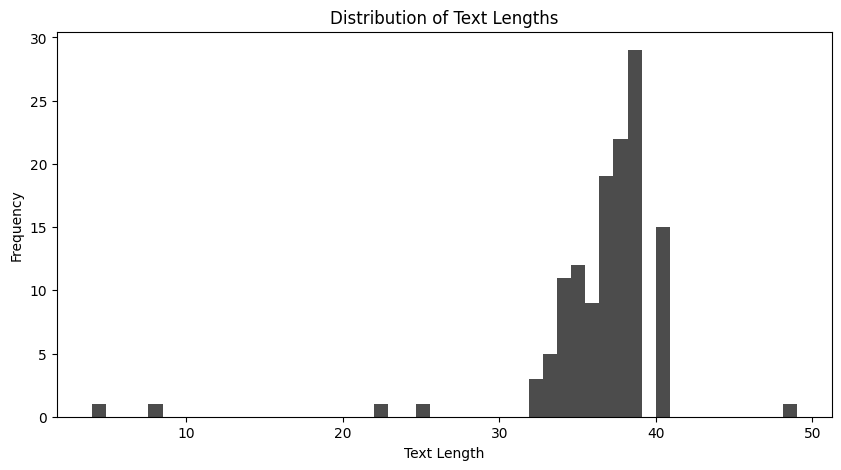

In [5]:
transcript_df['text_length'] = transcript_df['text'].apply(len)
plt.figure(figsize=(10, 5))
plt.hist(transcript_df['text_length'], bins=50, color='black', alpha=0.7)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

## Finding the most common words

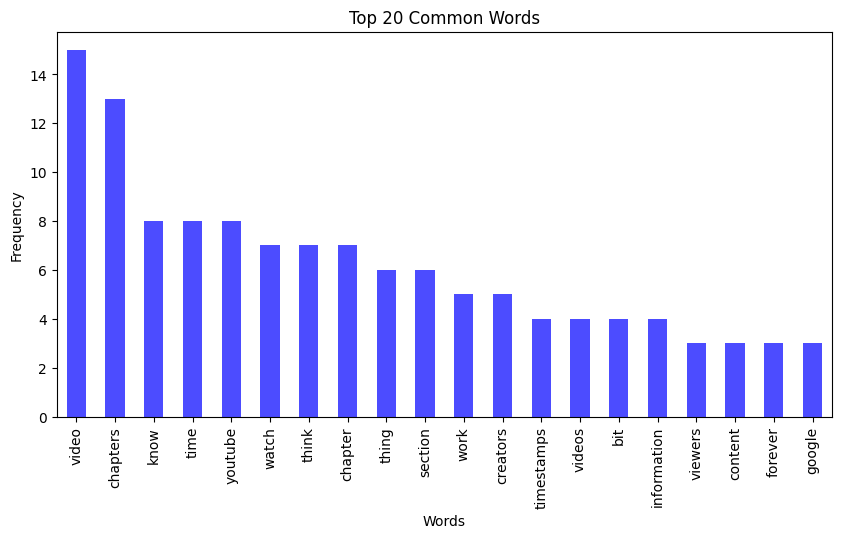

In [6]:
vectorizer = CountVectorizer(stop_words='english')
word_counts = vectorizer.fit_transform(transcript_df['text'])
word_counts_df = pd.DataFrame(word_counts.toarray(), columns=vectorizer.get_feature_names_out())
common_words = word_counts_df.sum().sort_values(ascending=False).head(20)
plt.figure(figsize=(10, 5))
common_words.plot(kind='bar', color='blue', alpha=0.7)
plt.title('Top 20 Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

## Topic Modeling using Non-negative Factorization (NMF)

In [7]:
n_features = 1000
n_topics = 10
n_top_words = 10

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf = tf_vectorizer.fit_transform(transcript_df['text'])
nmf = NMF(n_components=n_topics, random_state=42).fit(tf)
tf_feature_names = tf_vectorizer.get_feature_names_out()

def display_topics(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        topic_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics.append(" ".join(topic_words))
    return topics

topics = display_topics(nmf, tf_feature_names, n_top_words)
print("\nIdentified Topics:")
for i, topic in enumerate(topics):
    print(f"Topic {i + 1}: {topic}")


Identified Topics:
Topic 1: video content people relevant time information comments description like thing
Topic 2: chapters channel work people forever maybe like use creators watch
Topic 3: watch time forever ll second stop comments creators use think
Topic 4: chapter say like ll maybe skip let youtube time bit
Topic 5: know minutes comments think long video blogs label learn forever
Topic 6: section description going relevant second work content people youtube happened
Topic 7: youtube use creators viewers make learn videos chapter maybe time
Topic 8: think videos ve cliffhangers let watch comments google channel watched
Topic 9: timestamps google information help timestamp going let provide label skip
Topic 10: thing work creators exciting stop bit second just really clickbait


In [8]:
# get topic distribution for each text segment
topic_distribution = nmf.transform(tf)

# align the lengths by trimming the extra row in topic_distribution
topic_distribution_trimmed = topic_distribution[:len(transcript_df)]

# compute the dominant topic for each text segment
transcript_df['dominant_topic'] = topic_distribution_trimmed.argmax(axis=1)

In [9]:
# analyze the content of each text segment to manually identify logical breaks
logical_breaks = []

for i in range(1, len(transcript_df)):
    if transcript_df['dominant_topic'].iloc[i] != transcript_df['dominant_topic'].iloc[i - 1]:
        logical_breaks.append(transcript_df['start'].iloc[i])

In [10]:
# consolidate the logical breaks into broader chapters
threshold = 60  # seconds
consolidated_breaks = []
last_break = None

for break_point in logical_breaks:
    if last_break is None or break_point - last_break >= threshold:
        consolidated_breaks.append(break_point)
        last_break = break_point

In [11]:
# merge consecutive breaks with the same dominant topic
final_chapters = []
last_chapter = (consolidated_breaks[0], transcript_df['dominant_topic'][0])

for break_point in consolidated_breaks[1:]:
    current_topic = transcript_df[transcript_df['start'] == break_point]['dominant_topic'].values[0]
    if current_topic == last_chapter[1]:
        last_chapter = (last_chapter[0], current_topic)
    else:
        final_chapters.append(last_chapter)
        last_chapter = (break_point, current_topic)

final_chapters.append(last_chapter)  # append the last chapter

## Finally Chaptering

In [12]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming final_chapters, transcript_df, and other relevant variables are defined

chapter_points = []
chapter_names = []
chapter_texts = []

for i, (break_point, topic_idx) in enumerate(final_chapters):
    chapter_time = pd.to_datetime(break_point, unit='s').strftime('%H:%M:%S')
    chapter_points.append(chapter_time)

    # get the context for the chapter name and text
    chapter_text = transcript_df[(transcript_df['start'] >= break_point) & (transcript_df['dominant_topic'] == topic_idx)]['text'].str.cat(sep=' ')
    chapter_texts.append(chapter_text)

    # extract key phrases to create a chapter name
    vectorizer = TfidfVectorizer(stop_words='english', max_features=3)
    tfidf_matrix = vectorizer.fit_transform([chapter_text])
    feature_names = vectorizer.get_feature_names_out()
    chapter_name = " ".join(feature_names)

    chapter_names.append(f"Chapter {i+1}")

# Create DataFrame without an explicit index column
stamp_df = pd.DataFrame({
    'Time': chapter_points,
    'Chapter': chapter_names,
    'Text': chapter_texts
})

# Display the final stamp_df
print("\nFinal DataFrame (stamp_df):")
print(stamp_df)

# Optionally, you can also save stamp_df to a file if needed
# stamp_df.to_csv('chapter_stamps.csv', index=False)  # Example of saving to CSV file



Final DataFrame (stamp_df):
       Time    Chapter                                               Text
0  00:00:02  Chapter 1  weight viewers and creators use YouTube YouTub...
1  00:01:03  Chapter 2  labeled up you can just skip to the bit you ca...
2  00:02:04  Chapter 3  Google ranking signals I think so let me them ...
3  00:03:08  Chapter 4  chapters more like people to video being calle...
4  00:04:08  Chapter 5             watch it and think nonsense watch this
